<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [3]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' en el año 1872, la casa número 7 de saville-row, burlington gardens \r\n—donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a\r\n pesar de que parecía haber tomado el partido de no hacer nada que \r\npudiese llamar la atención, era uno de los miembros más notables y \r\nsingulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo \r\nse sabía que era un hombre muy galante y de los más cumplidos gentlemen \r\nde la alta sociedad inglesa, sucedía a uno de los más grandes oradores \r\nque honran a inglaterra. decíase que se daba un aire a lo byron —su cabeza, se entiende, \r\nporque, en cuanto a los pies, no tenía defecto alguno—, pero a un byron \r\nde bigote y pastillas, a un byron impasible, que hubiera vivido mil años\r\n sin envejecer. phileas fogg, era inglés de pura cepa; pero quizás no había nacido en\r\n londres. jamás se le había visto en la bolsa ni en el banco, ni en \r\nninguno de los despachos mercantiles de 

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

68

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [11]:
tokenized_text[:1000]

[67,
 20,
 62,
 67,
 20,
 28,
 67,
 38,
 37,
 45,
 67,
 8,
 63,
 2,
 34,
 59,
 67,
 28,
 38,
 67,
 42,
 38,
 5,
 38,
 67,
 62,
 27,
 14,
 20,
 15,
 45,
 67,
 2,
 67,
 10,
 20,
 67,
 5,
 38,
 61,
 16,
 28,
 28,
 20,
 21,
 15,
 45,
 3,
 59,
 67,
 18,
 52,
 15,
 28,
 16,
 62,
 29,
 39,
 45,
 62,
 67,
 29,
 38,
 15,
 10,
 20,
 62,
 5,
 67,
 53,
 17,
 22,
 10,
 45,
 62,
 10,
 20,
 67,
 14,
 52,
 15,
 16,
 56,
 67,
 5,
 4,
 20,
 15,
 16,
 10,
 38,
 62,
 67,
 20,
 62,
 67,
 8,
 63,
 8,
 0,
 22,
 67,
 20,
 5,
 39,
 38,
 18,
 38,
 67,
 4,
 38,
 18,
 16,
 39,
 38,
 10,
 38,
 67,
 31,
 45,
 15,
 67,
 31,
 4,
 16,
 28,
 20,
 38,
 5,
 67,
 46,
 45,
 29,
 29,
 59,
 67,
 64,
 52,
 16,
 20,
 62,
 67,
 38,
 53,
 17,
 67,
 31,
 20,
 5,
 38,
 15,
 67,
 10,
 20,
 67,
 64,
 52,
 20,
 67,
 31,
 38,
 15,
 20,
 42,
 54,
 38,
 67,
 4,
 38,
 18,
 20,
 15,
 67,
 39,
 45,
 14,
 38,
 10,
 45,
 67,
 20,
 28,
 67,
 31,
 38,
 15,
 39,
 16,
 10,
 45,
 67,
 10,
 20,
 67,
 62,
 45,
 67,
 4,
 38,
 42,
 20,
 15,
 67,
 62,

### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
X.shape

(359671, 100)

In [18]:
X[0,:10]

array([67, 20, 62, 67, 20, 28, 67, 38, 37, 45])

In [19]:
y[0,:10]

array([20, 62, 67, 20, 28, 67, 38, 37, 45, 67])

In [21]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [4]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [23]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

C:\Users\Zeus\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        53,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 68)       │        13,668 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,468 (263.55 KB)

 Trainable params: 67,468 (263.55 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [5]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_LSTM_GRU.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [27]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.9319
 mean perplexity: 5.463329971548727 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 159s 113ms/step - loss: 1.9319
Epoch 2/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.8244
 mean perplexity: 5.1776457288549915 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 161s 114ms/step - loss: 1.8244
Epoch 3/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.7775
 mean perplexity: 5.029675203562252 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 158s 113ms/step - loss: 1.7775
Epoch 4/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.7509
 mean perplexity: 5.021168272170228 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 160s 114ms/step - loss: 1.7508
Epoch 5/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.7326
 mean perplexity: 4.907666872095143 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - loss: 1.7326
Epoch 6/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss:

c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


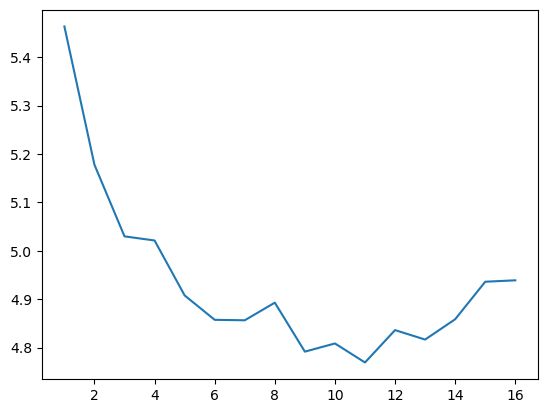

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [30]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [32]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [34]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [49]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [36]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez en cuando el capitán de la ca'

###  Beam search y muestreo aleatorio

In [51]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [39]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [40]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [41]:
salidas[0]

array([ 4, 38, 18, 16, 38, 67, 52, 62, 38, 67, 61, 20, 40, 67, 20, 62, 39,
       15, 20, 67, 28, 38, 67, 42, 45, 14, 31, 38, 37, 20, 15, 45,  5])

In [42]:
# veamos las salidas
decode(salidas[0])

'habia una vez entre la compañeros'

#### --------------------------------Desafio 3----------------------------------

Corpus de texto
    Utilizaremos la obra el retrato de Dorian Gray de Oscar Wilde tomado del sitio recomendado www.texto.info

In [6]:
import urllib.request
import re

In [37]:
url = "https://www.textos.info/oscar-wilde/el-retrato-de-dorian-gray/pdf"
urllib.request.urlretrieve(url, "el-retrato-de-dorian-gray.pdf")
print("Archivo PDF descargado exitosamente.")

Archivo PDF descargado exitosamente.


In [38]:
#convertir archivo pfd a texto
import fitz
def pdf_to_txt(pdf_path, txt_path):
    pdf_document = fitz.open(pdf_path)
    text = ""
    for page in pdf_document:
        text += page.get_text()
    with open(txt_path, "w", encoding="utf-8") as txt_file:
        txt_file.write(text)

    print(f"Archivo convertido a TXT almacenado en {txt_path}")
pdf_to_txt("el-retrato-de-dorian-gray.pdf", "el-retrato-de-dorian-gray.txt")  # se genera nuevo archivo modificado con la limpieza y normalizacion del texto

Archivo convertido a TXT almacenado en el-retrato-de-dorian-gray.txt


In [7]:
# Leer el archivo de texto
with open("el-retrato-de-dorian-gray.txt", "r", encoding="utf-8") as file:
    text = file.read()
# Normalizacion de  texto a minusculas, eliminacion de caracterias diferentes a alfabeticos
text = text.lower()
text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
text = re.sub(r'[!?]', '', text)  
text = re.sub(r' +', ' ', text)
archivo=open("el-retrato-de-dorian-gray_mod.txt", "w", encoding="utf-8") 
archivo.write(text)
archivo.close()

In [ ]:
# Mostrar el texto extraído (opcional)
print(text[:1000])  # Muestra los primeros 1000 caracteres

In [8]:
# Armar el dataset 
df = pd.read_fwf('el-retrato-de-dorian-gray_mod.txt')
df.head(15)

,el retrato de dorian gray
0,oscar wilde
1,textosinfo
2,biblioteca digital abierta
3,texto núm
4,título el retrato de dorian gray
5,autor oscar wilde
6,etiquetas novela
7,editor edu robsy
8,fecha de creación de mayo de
9,fecha de modificación de noviembre de


In [9]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [10]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [11]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(text)

In [12]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

35

In [13]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [14]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in text]

In [15]:
tokenized_text[:1000]

[0,
 18,
 16,
 26,
 2,
 18,
 12,
 2,
 22,
 12,
 27,
 26,
 30,
 18,
 26,
 30,
 27,
 2,
 13,
 22,
 9,
 26,
 14,
 2,
 22,
 34,
 0,
 27,
 17,
 8,
 22,
 2,
 26,
 33,
 13,
 16,
 30,
 18,
 0,
 12,
 18,
 24,
 12,
 27,
 17,
 13,
 9,
 23,
 27,
 0,
 19,
 13,
 19,
 16,
 13,
 27,
 12,
 18,
 8,
 22,
 26,
 30,
 13,
 14,
 13,
 12,
 22,
 16,
 26,
 22,
 19,
 13,
 18,
 2,
 12,
 22,
 0,
 0,
 12,
 18,
 24,
 12,
 27,
 26,
 9,
 25,
 21,
 26,
 0,
 12,
 7,
 12,
 28,
 16,
 27,
 26,
 18,
 16,
 26,
 2,
 18,
 12,
 2,
 22,
 12,
 27,
 26,
 30,
 18,
 26,
 30,
 27,
 2,
 13,
 22,
 9,
 26,
 14,
 2,
 22,
 34,
 0,
 22,
 28,
 12,
 27,
 2,
 26,
 27,
 17,
 8,
 22,
 2,
 26,
 33,
 13,
 16,
 30,
 18,
 0,
 18,
 12,
 13,
 32,
 28,
 18,
 12,
 22,
 17,
 26,
 9,
 27,
 31,
 18,
 16,
 22,
 0,
 18,
 30,
 13,
 12,
 27,
 2,
 26,
 18,
 30,
 28,
 26,
 2,
 27,
 19,
 17,
 34,
 0,
 23,
 18,
 8,
 4,
 22,
 26,
 30,
 18,
 26,
 8,
 2,
 18,
 22,
 8,
 13,
 20,
 9,
 26,
 30,
 18,
 26,
 21,
 22,
 34,
 27,
 26,
 30,
 18,
 26,
 0,
 23,
 18,
 8,
 4,
 22

### Organizando y estructurando el dataset

In [16]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [17]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [18]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [19]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [20]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [21]:
X.shape

(402795, 100)

In [22]:
X[0,:10]

array([ 0, 18, 16, 26,  2, 18, 12,  2, 22, 12])

In [23]:
y[0,:10]

array([18, 16, 26,  2, 18, 12,  2, 22, 12, 27])

In [24]:
vocab_size = len(chars_vocab)

In [25]:
print(vocab_size)

35


# Definiendo el modelo

In [63]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [64]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

C:\Users\Zeus\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 35)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 200)      │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 35)       │         7,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,235 (211.86 KB)

 Trainable params: 54,235 (211.86 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [65]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 2.3010
 mean perplexity: 6.162499363421203 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 174s 109ms/step - loss: 2.3009
Epoch 2/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.8776
 mean perplexity: 5.347742486443803 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 180s 115ms/step - loss: 1.8776
Epoch 3/20
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.7856
 mean perplexity: 5.120424526846933 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 179s 114ms/step - loss: 1.7856
Epoch 4/20
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.7468
 mean perplexity: 5.0332245323196245 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 174s 111ms/step - loss: 1.7468
Epoch 5/20
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.7236
 mean perplexity: 4.919021250629871 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - loss: 1.7236
Epoch 6/20
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1

c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


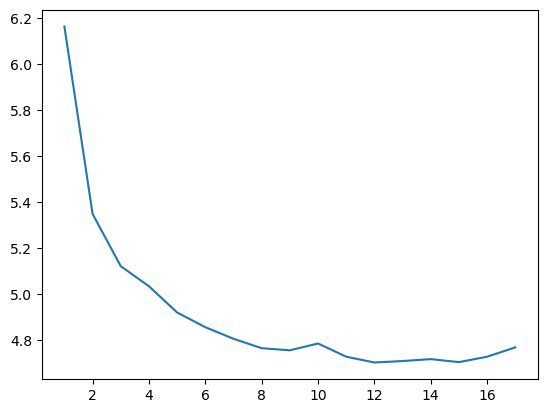

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [68]:
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [70]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [38]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

C:\Users\Zeus\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [41]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [93]:
input_text='Dorian'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Dorian gray se alegría de la mesa de'

In [73]:
input_text='No es demasiado lo que'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'No es demasiado lo que es una mano de la mesa de la '

In [90]:
input_text='un pobre desgraciado tiene'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'un pobre desgraciado tiene se había algo que es una mano'

Se puede obervar que genera palabras que particularmente estan correctas, incluso agrupando palabras hacen mucho sentido y en otros casos se pierde un poco el contexto como el segundo y tercer ejemplo

Beam search y muestreo aleatorio

In [94]:
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [47]:
from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    encoded = encode(input)

  
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        input_update = np.array([hist[i+1:]]).copy()

        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [97]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="el intenso perfume")

In [98]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 13, 34,
        7, 32, 19, 11, 32,  2, 23, 34, 15, 11,  8, 24, 27,  6, 11, 32, 19,
       11, 34, 13, 23, 34, 33, 27, 11, 34,  2, 11, 34,  3, 18, 10, 28, 18,
       34])

In [99]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwel intenso perfumente lo que se había '

In [101]:
salidas = beam_search(model,num_beams=10,num_words=20,input="el pintor se mordio")

In [102]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 13, 34, 15,
        7, 32, 19, 23,  8, 34,  2, 11, 34,  6, 23,  8,  4,  7, 23, 34, 13,
       23, 34, 33, 27, 11, 34,  3, 18, 10, 28, 18, 34, 11, 32, 34, 11, 13,
       34])

In [103]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwel pintor se mordio lo que había en el '

In [104]:
salidas = beam_search(model,num_beams=10,num_words=20,input="la horrible noche")

In [105]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 18,
       34,  3, 23,  8,  8,  7, 10, 13, 11, 34, 32, 23, 21,  3, 11, 34, 13,
       23, 34, 33, 27, 11, 34,  3, 18, 10, 28, 18, 34, 11, 32, 34, 11, 13,
       34])

In [106]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwla horrible noche lo que había en el '

In [107]:
salidas = beam_search(model,num_beams=10,num_words=20,input="el frescor del aire")

In [108]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 13, 34, 24,
        8, 11,  2, 21, 23,  8, 34,  4, 11, 13, 34, 18,  7,  8, 11, 34,  4,
       11, 34, 13, 23,  2, 34, 23,  5, 23,  2, 34,  4, 11, 34, 27, 32, 18,
       34])

In [109]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwel frescor del aire de los ojos de una '

Modelo LSTM

In [110]:
# Definir el modelo
from tensorflow.keras.optimizers import RMSprop
model_lstm = Sequential()

# Añadir capas
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo con una learning rate específica
optimizer = RMSprop(learning_rate=0.0001)  # Aquí puedes ajustar la learning rate según lo necesites
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# Compilar el modelo
#model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

# Mostrar el resumen del modelo
model_lstm.summary()

C:\Users\Zeus\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 35)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       188,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 35)       │         7,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,835 (764.98 KB)

 Trainable params: 195,835 (764.98 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento

In [126]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 1.9008
 mean perplexity: 5.989467553101445 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 482s 306ms/step - loss: 1.9008
Epoch 2/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 1.8952
 mean perplexity: 5.938593419501447 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 562s 357ms/step - loss: 1.8952
Epoch 3/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 1.8874
 mean perplexity: 5.910723155166846 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 562s 357ms/step - loss: 1.8874
Epoch 4/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 1.8813
 mean perplexity: 5.882962394670156 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 532s 338ms/step - loss: 1.8813
Epoch 5/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1.8756
 mean perplexity: 5.85397756899752 

Saved new model!
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 548s 348ms/step - loss: 1.8756
Epoch 6/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - los

c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


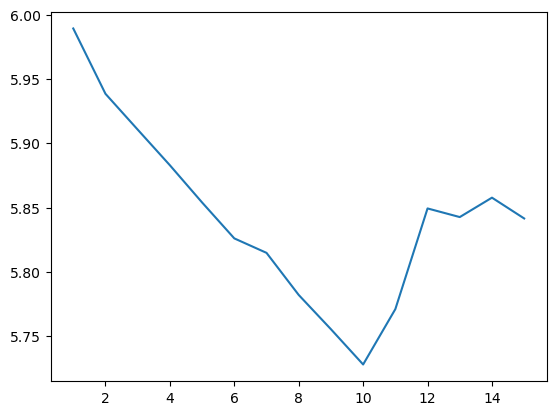

In [127]:
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [128]:
model = keras.models.load_model('my_model_LSTM_CHAR.keras')

In [129]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Keyboard interruption in main thread... closing server.


Generación de secuencias

In [130]:
input_text='Dorian'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Dorian gray de la mano de la mano de'

In [131]:
input_text='No es demasiado lo que'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'No es demasiado lo que es el mucho de la mano de la '

In [132]:
input_text='un pobre desgraciado tiene'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'un pobre desgraciado tienes de la mano de la mano de la '

Beam search y muestreo aleatorio

In [133]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="el intenso perfume")

In [134]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 13, 34,
        7, 32, 19, 11, 32,  2, 23, 34, 15, 11,  8, 24, 27,  6, 11, 32, 19,
       11, 34,  4, 11, 34, 13, 18,  2, 34, 15, 11,  8,  2, 23, 32, 18,  2,
       34])

In [135]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwel intenso perfumente de las personas '

In [136]:

salidas = beam_search(model,num_beams=10,num_words=20,input="el pintor se mordio")

In [137]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 13, 34, 15,
        7, 32, 19, 23,  8, 34,  2, 11, 34,  6, 23,  8,  4,  7, 23,  2, 34,
        4, 11, 34, 13, 18, 34, 31,  7,  4, 18, 34,  4, 11, 34, 13, 18,  2,
       34])

In [138]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwel pintor se mordios de la vida de las '

In [139]:
salidas = beam_search(model,num_beams=10,num_words=20,input="la horrible noche")

In [140]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 18,
       34,  3, 23,  8,  8,  7, 10, 13, 11, 34, 32, 23, 21,  3, 11, 34,  3,
       18, 10, 28, 18, 34,  4, 11, 34, 13, 18, 34, 31,  7,  4, 18, 34,  4,
       11])

In [141]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwla horrible noche había de la vida de'

In [142]:
salidas = beam_search(model,num_beams=10,num_words=20,input="el frescor del aire")

In [143]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 13, 34, 24,
        8, 11,  2, 21, 23,  8, 34,  4, 11, 13, 34, 18,  7,  8, 11,  2, 34,
        4, 11, 34, 13, 18, 34, 31,  7,  4, 18, 34,  4, 11, 34, 13, 18,  2,
       34])

In [144]:
decode(salidas[0])

'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwel frescor del aires de la vida de las '

Modelo GRU

In [27]:
from tensorflow.keras.layers import TimeDistributed, Dense, GRU
# Definir el modelo
from tensorflow.keras.optimizers import RMSprop
model_gru = Sequential()

# Añadir capas
model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.0))
model_gru.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo con una learning rate específica
optimizer = RMSprop(learning_rate=0.0001)  # Aquí puedes ajustar la learning rate según lo necesites
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# Compilar el modelo
#model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

# Mostrar el resumen del modelo
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, None, 35)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, None, 200)         142200    
                                                                 
 dense_1 (Dense)             (None, None, 35)          7035      
                                                                 
Total params: 149,235
Trainable params: 149,235
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_ppl = []
hist = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1574/1574 [==============================] - ETA: 0s - loss: 2.5272
 mean perplexity: 8.83315881437757 

Saved new model!
1574/1574 [==============================] - 50s 26ms/step - loss: 2.5272
Epoch 2/20
1574/1574 [==============================] - ETA: 0s - loss: 2.1245
 mean perplexity: 7.310885033043115 

Saved new model!
1574/1574 [==============================] - 38s 24ms/step - loss: 2.1245
Epoch 3/20
1572/1574 [============================>.] - ETA: 0s - loss: 1.9757
 mean perplexity: 6.505965861660676 

Saved new model!
1574/1574 [==============================] - 37s 24ms/step - loss: 1.9756
Epoch 4/20
1573/1574 [============================>.] - ETA: 0s - loss: 1.8730
 mean perplexity: 5.99960911291254 

Saved new model!
1574/1574 [==============================] - 37s 23ms/step - loss: 1.8730
Epoch 5/20
1574/1574 [==============================] - ETA: 0s - loss: 1.7951
 mean perplexity: 5.653279257850974 

Saved new model!
1574/1574 [=========================

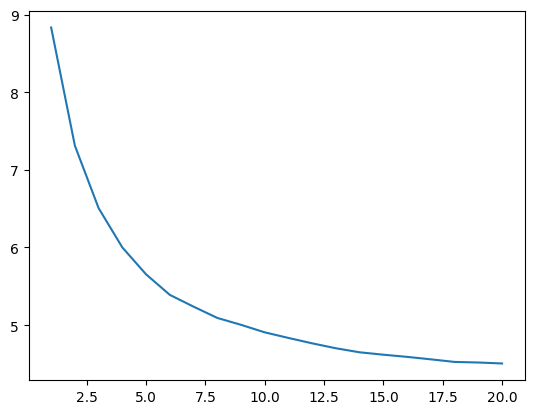

In [31]:
import seaborn as sns
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [34]:
model = keras.models.load_model('my_model_GRU.keras')

In [39]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 41ms/step
Keyboard interruption in main thread... closing server.


Generación de secuencias

In [42]:
input_text='Dorian'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Dorian gray se le parece que la muje'

In [43]:
input_text='No es demasiado lo que'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'No es demasiado lo que había desaparecido de la cabe'

In [45]:
input_text='un pobre desgraciado tiene'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'un pobre desgraciado tiene una corazón de la cabeza de '

GRU Beam search y muestreo aleatorio

In [52]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="el intenso perfume")

In [53]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 16, 26,
       13,  9, 12, 18,  9, 17, 27, 26,  6, 18,  2, 23, 28, 21, 18, 26, 30,
       18, 26, 16, 27,  2, 30, 26,  4, 18,  9,  2, 34, 26,  8, 27,  9, 26,
       28])

In [54]:
decode(salidas[0])

'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjel intenso perfume de lord henry con u'

In [55]:
salidas = beam_search(model,num_beams=10,num_words=20,input="el pintor se mordio")

In [56]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 16, 26,  6,
       13,  9, 12, 27,  2, 26, 17, 18, 26, 21, 27,  2, 30, 13, 27, 26, 18,
        9, 26, 16, 22, 26,  8, 22, 19, 18, 11, 22, 26,  8, 27,  9, 26, 28,
        9])

In [57]:
decode(salidas[0])

'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjel pintor se mordio en la cabeza con un'

In [58]:
salidas = beam_search(model,num_beams=10,num_words=20,input="la horrible noche")

In [59]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 22,
       26,  4, 27,  2,  2, 13, 19, 16, 18, 26,  9, 27,  8,  4, 18, 26, 17,
       18, 26,  4, 22, 19,  7, 22, 26,  6, 18,  2, 30, 13, 30, 27, 26, 18,
       16])

In [60]:
decode(salidas[0])

'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjla horrible noche se había perdido el'

In [61]:
salidas = beam_search(model,num_beams=10,num_words=20,input="el frescor del aire")

In [62]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 16, 26, 23,
        2, 18, 17,  8, 27,  2, 26, 30, 18, 16, 26, 22, 13,  2, 18, 26,  2,
       18, 17,  6, 27,  9, 30, 13, 20, 26, 16, 27,  2, 30, 26,  4, 18,  9,
        2])

In [63]:
decode(salidas[0])

'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjnel frescor del aire respondió lord henr'

##### Se hizo la evaluacion de las tres alternativas, SIMPLERNN,LSTM y GRU,
#### en terminos de perplejidad SIMPLERNN y GRU dieron resultados similares, pero en la practica SimpleRNN da resultados mas coherentes de entender, es debido al largo de secuencias.
#### El modelo detecta perfectamente los personas principales.
#### En el archivo pdf adjunto en el repo se muestran las secuencia obtenidas por gradio ademas de los modelos entrenados.